# [UE Side Implementation]-Downlink Time/Frame Synchronization using PSS in 5G Networks

## Import Libraries

### Import Some Basic Python Libraries

In [1]:

# from IPython.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# %matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation

import numpy as np
import adi


### Import 5G Libraries

In [2]:
from toolkit5G.SequenceGeneration import PSS, SSS, DMRS
from toolkit5G.PhysicalChannels   import PBCH, PBCHDecoder
from toolkit5G.ResourceMapping    import SSB_Grid, ResourceMapperSSB
from toolkit5G.OFDM               import OFDMModulator, OFDMDemodulator
from toolkit5G.MIMOProcessing     import AnalogBeamforming, ReceiveCombining
from toolkit5G.ReceiverAlgorithms import PSSDetection, SSSDetection, ChannelEstimationAndEqualization, DMRSParameterDetection
from toolkit5G.Configurations     import TimeFrequency5GParameters, GenerateValidSSBParameters

## Emulation Parameters

In [3]:
# System Parameters
center_frequency    = 1e9 # Hz

# OFDM Parameters
Bandwidth           = 5*10**6
fftSize             = 1024
subcarrier_spacing  = 15000
numOFDMSymbols      = 14
sample_rate         = fftSize*subcarrier_spacing

# Pulse Shaping
numSamplesPerSymbol = 1


# number of samples returned per call to rx()
buffer_size         = int(fftSize*1.2*numSamplesPerSymbol*numOFDMSymbols) 

## SDR-Setup Configurations

In [4]:
# Basic SDR Setup
sdr = adi.Pluto("ip:192.168.2.1")
sdr.sample_rate = int(sample_rate)

# Config Tx
sdr.tx_rf_bandwidth = int(sample_rate) # filter cutoff, just set it to the same as sample rate
sdr.tx_lo           = int(center_frequency)
sdr.tx_hardwaregain_chan0 = -0 # Increase to increase tx power, valid range is -90 to 0 dB

# Config Rx
sdr.gain_control_mode_chan0 = 'manual'
sdr.rx_hardwaregain_chan0   = 40.0      # dB
# The receive gain on the Pluto has a range from 0 to 74.5 dB.

# sdr.gain_control_mode_chan0 = 'slow_attack'
# # AGC modes: 
#     # 1. "manual"
#     # 2. "slow_attack"
#     # 3. "fast_attack"

sdr.rx_lo           = int(center_frequency)
sdr.rx_rf_bandwidth = int(60*10**6) # filter width, just set it to the same as sample rate for now
sdr.rx_buffer_size  = int(buffer_size)

## Reception: SDR RF Receiver

In [5]:

# Clear buffer just to be safe
for i in range (0, 10):
    raw_data = sdr.rx()

# Receive samples
rx_samples = sdr.rx()

# # Stop transmitting
# sdr.tx_destroy_buffer()


## Time Frequency Configurations

In [6]:
## This class fetches valid set of 5G parameters for the system configurations
nSymbolFrame= int(140*subcarrier_spacing/15000)
## This class fetches valid set of 5G parameters for the system configurations 
tfParams    = TimeFrequency5GParameters(Bandwidth, subcarrier_spacing)
tfParams(nSymbolFrame, typeCP = "normal")
nRB         = tfParams.numRBs        # SSB Grid size (Number of RBs considered for SSB transition)
Neff        = tfParams.Neff        # Number of resource blocks for Resource Grid ( exclude gaurd band | offsets : BWP)
Nfft        = 512                 # FFT-size for OFDM
lengthCP    = tfParams.lengthCP    # CP length

## Time Synchronization: Based on PSS Correlation

**(rasterOffset, PSS-ID) (362, 0)
**(rasterOffset, PSS-ID) (362, 1)
**(rasterOffset, PSS-ID) (362, 2)


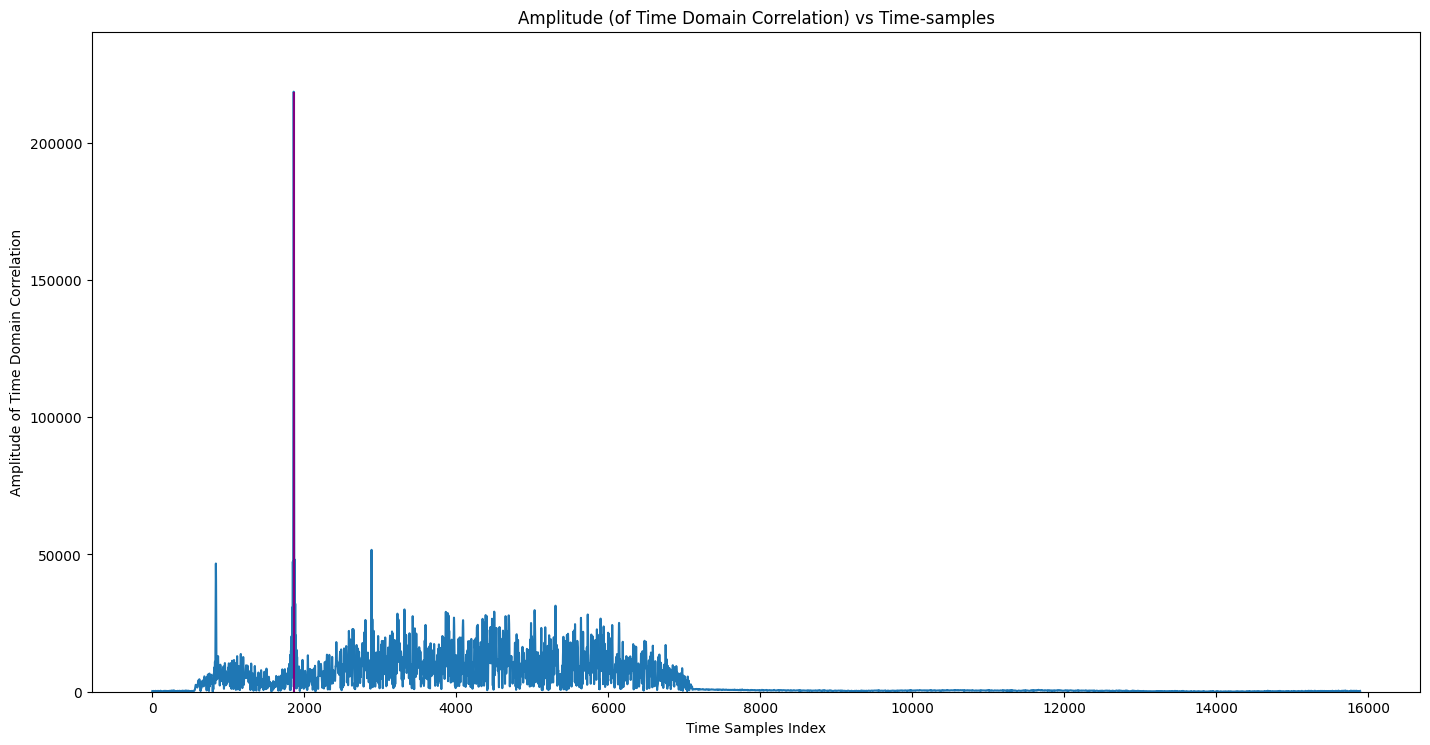

In [7]:
## PSS Detection: Based on time domain PSS Correlation
startingSubcarrierIndices = 0
pssDetection   = PSSDetection("largestPeak")
ssboffset      = int((fftSize-Neff)/2+startingSubcarrierIndices)
pssPeakIndices, pssCorrelation, rN_ID2, freqOffset = pssDetection(rx_samples, fftSize, lengthCP = lengthCP[1], 
                                                                  nID2=None, freqOffset = ssboffset)

## PSS Detection Plot
#################################################################
scaleFig = 1.75
fig, ax  = plt.subplots(figsize=(30/scaleFig, 15/scaleFig))

# single line
ax.plot(pssCorrelation)
ax.vlines(x = pssPeakIndices, ymin = 0*pssCorrelation[pssPeakIndices],
           ymax = pssCorrelation[pssPeakIndices], colors = 'purple')
ax.set_ylim([0,np.max(pssCorrelation)*1.1])
ax.set_xlabel("Time Samples Index")
ax.set_ylabel("Amplitude of Time Domain Correlation")
ax.set_title("Amplitude (of Time Domain Correlation) vs Time-samples")
plt.show()
#________________________________________________________________